<h2><center> Rock, Paper, Scissors - "Beat a human" strategy </center></h2>

<img src="https://www.clipartmax.com/png/middle/428-4288829_rock-paper-scissors-rock-paper-scissors.png" alt="Rock, Paper, Scissors">

I recently came across [the paper](https://doi.org/10.1038/srep05830) on humans decisions in the rock-paper-scissors game (see preprint on [arXiv](https://arxiv.org/abs/1404.5199)). It reveals the presence of cyclic motions in collective behavior: winners are more likely to repeat their previous actions. And losers are more likely to copy the last opponent's action. Conversely, this behavior can be easily exploited:

+ if won - use last opponent action
+ if lose - pick action which would have beaten the opponent in the previous game (i.e. what didn't appear in the previous game)
+ if draw - choose the next action randomly

While this competition is focused on sophisticated history-based strategies, it is still interesting, how the "beat a human" strategy performs against those bots. So, let's create the "beat a human" bot:

In [1]:
%%writefile beat_a_human.py

from random import randint
action = 0

def get_outcome(action, opponent_action):
    """ Return the outcome of the previous game """
    if action == ((opponent_action + 1) % 3):
        outcome = 1     # win
    elif opponent_action == ((action + 1) % 3):
        outcome = -1    # lose
    else:
        outcome = 0     # draw
    return outcome

def beat_a_human_agent(observation, configuration):
    """ Return an action: 0 - Rock, 1 - Paper, 2 - Scissors """
    global action    
    if observation.step == 0:
        action = randint(0, 2)
    else:
        previous_outcome = get_outcome(action, observation.lastOpponentAction)
        if previous_outcome == -1:
            action = list({0,1,2} - {action, observation.lastOpponentAction})[0]
        elif previous_outcome == 1:
            action = observation.lastOpponentAction
        else:
            action = randint(0, 2)
    return action

Writing beat_a_human.py


In [2]:
# test result
from kaggle_environments import make
env = make("rps", configuration={"episodeSteps": 1000}, debug = True)

env.reset()
env.run(["beat_a_human.py", "beat_a_human.py"])
env.render(mode="ipython", width=550, height=500)

Loading environment football failed: No module named 'gfootball'


Now let's test results against other simple strategies:
+ always play rock
+ always play paper
+ always play scissors
+ always chose randomly (nash equilibrium)
+ copy opponent (play the competitor's last action)
+ mirror opponent with fixed shift 1 or 2
+ shift own last play with 1 or 2

In [3]:
%%writefile always_rock.py

def always_rock_agent(observation, configuration):
    return 0

Writing always_rock.py


In [4]:
%%writefile always_paper.py

def always_paper_agent(observation, configuration):
    return 1

Writing always_paper.py


In [5]:
%%writefile always_scissors.py

def always_scissors_agent(observation, configuration):
    return 2

Writing always_scissors.py


In [6]:
%%writefile nash_equilibrium.py

import random

def nash_equilibrium_agent(observation, configuration):
    return random.randint(0, 2)

Writing nash_equilibrium.py


In [7]:
%%writefile copy_opponent.py

def copy_opponent_agent(observation, configuration):
    if observation.step > 0:
        return observation.lastOpponentAction
    else:
        return 0

Writing copy_opponent.py


In [8]:
%%writefile mirror_shift_opponent_1.py

def mirror_shift_opponent_1_agent(observation, configuration):
    if observation.step > 0:
        return (observation.lastOpponentAction + 1) % 3
    else:
        return 0

Writing mirror_shift_opponent_1.py


In [9]:
%%writefile mirror_shift_opponent_2.py

def mirror_shift_opponent_2_agent(observation, configuration):
    if observation.step > 0:
        return (observation.lastOpponentAction + 2) % 3
    else:
        return 0

Writing mirror_shift_opponent_2.py


In [10]:
%%writefile shift_own_play_1.py

def mirror_shift_opponent_1_1(observation, configuration):
    if observation.step > 0:
        return (observation.lastAction + 1) % 3
    else:
        return 0

Writing shift_own_play_1.py


In [11]:
%%writefile shift_own_play_2.py

def shift_own_play_2(observation, configuration):
    if observation.step > 0:
        return (observation.lastAction + 2) % 3
    else:
        return 0 

Writing shift_own_play_2.py


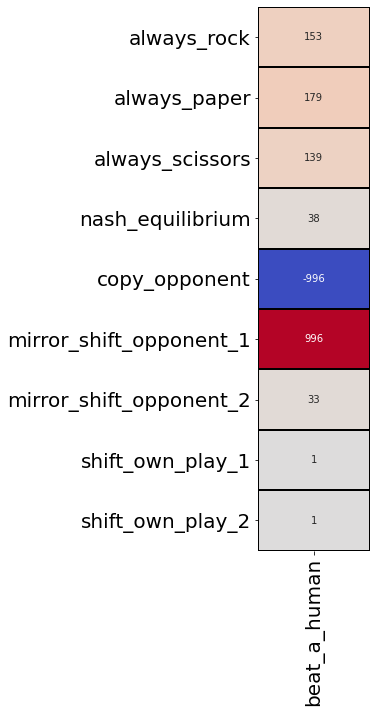

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from kaggle_environments import make, evaluate

env = make("rps", configuration={"episodeSteps": 1000})

list_names = [
    "always_rock", 
    "always_paper", 
    "always_scissors",
    "nash_equilibrium",  
    "copy_opponent", 
    "mirror_shift_opponent_1", 
    "mirror_shift_opponent_2",
    "shift_own_play_1",
    "shift_own_play_2"
]
list_agents = [agent_name + ".py" for agent_name in list_names]

scores = np.zeros((len(list_names), 1), dtype=int)

for agent_number in range(len(list_names)):
    current_agent = list_agents[agent_number]
    current_score = evaluate(
        "rps", 
        ["beat_a_human.py", current_agent], 
        configuration={"episodeSteps": 1000}
    )
    scores[agent_number, 0] = current_score[0][0]
df_scores = pd.DataFrame(scores, index=list_names, columns=["beat_a_human"])

plt.figure(figsize=(2, 10))
sns.heatmap(
    df_scores, annot=True, cbar=False, 
    cmap="coolwarm", linewidths=1, linecolor="black", 
    fmt="d", vmin=-1000, vmax=1000,
)
plt.xticks(rotation=90, fontsize=20)
plt.yticks(rotation=360, fontsize=20);

Not surprisingly, "Beat a human" defeats bot with the strategy of mirror shift by 1. However, it is beaten by the "copycat" bot. There is also OK performance against constant play bots and tie with the rest.

Now it is interesting to look at efficiency against stronger bots. Specifically, we test it against "Blue Belt" and "Black Belt" [bots](https://www.kaggle.com/chankhavu/rps-dojo).

In [13]:
%%writefile statistical.py
import random
from kaggle_environments.envs.rps.utils import get_score

action_histogram = {}


def statistical(observation, configuration):
    global action_histogram
    if observation.step == 0:
        action_histogram = {}
        return
    action = observation.lastOpponentAction
    if action not in action_histogram:
        action_histogram[action] = 0
    action_histogram[action] += 1
    mode_action = None
    mode_action_count = None
    for k, v in action_histogram.items():
        if mode_action_count is None or v > mode_action_count:
            mode_action = k
            mode_action_count = v
            continue

    return (mode_action + 1) % configuration.signs

Writing statistical.py


In [14]:
%%writefile not_so_markov.py

import numpy as np
import collections

def markov_agent(observation, configuration):
    k = 2
    global table, action_seq
    if observation.step % 250 == 0: # refresh table every 250 steps
        action_seq, table = [], collections.defaultdict(lambda: [1, 1, 1])    
    if len(action_seq) <= 2 * k + 1:
        action = int(np.random.randint(3))
        if observation.step > 0:
            action_seq.extend([observation.lastOpponentAction, action])
        else:
            action_seq.append(action)
        return action
    # update table
    key = ''.join([str(a) for a in action_seq[:-1]])
    table[key][observation.lastOpponentAction] += 1
    # update action seq
    action_seq[:-2] = action_seq[2:]
    action_seq[-2] = observation.lastOpponentAction
    # predict opponent next move
    key = ''.join([str(a) for a in action_seq[:-1]])
    if observation.step < 500:
        next_opponent_action_pred = np.argmax(table[key])
    else:
        scores = np.array(table[key])
        next_opponent_action_pred = np.random.choice(3, p=scores/scores.sum()) # add stochasticity for second part of the game
    # make an action
    action = (next_opponent_action_pred + 1) % 3
    # if high probability to lose -> let's surprise our opponent with sudden change of our strategy
    if observation.step > 900:
        action = next_opponent_action_pred
    action_seq[-1] = action
    return int(action)

Writing not_so_markov.py


In [15]:
%%writefile transition_matrix.py

import numpy as np
import pandas as pd
import random

T = np.zeros((3, 3))
P = np.zeros((3, 3))

# a1 is the action of the opponent 1 step ago
# a2 is the action of the opponent 2 steps ago
a1, a2 = None, None

def transition_agent(observation, configuration):
    global T, P, a1, a2
    if observation.step > 1:
        a1 = observation.lastOpponentAction
        T[a2, a1] += 1
        P = np.divide(T, np.maximum(1, T.sum(axis=1)).reshape(-1, 1))
        a2 = a1
        if np.sum(P[a1, :]) == 1:
            return int((np.random.choice(
                [0, 1, 2],
                p=P[a1, :]
            ) + 1) % 3)
        else:
            return int(np.random.randint(3))
    else:
        if observation.step == 1:
            a2 = observation.lastOpponentAction
        return int(np.random.randint(3))

Writing transition_matrix.py


In [16]:
%%writefile stochastic_transition_matrix.py
import numpy as np
import json
#import torch

matrix = np.ones((3,3,3)) * (1/3) #so we can choose object based on what we chose and what the opponent chose transition matrix
matrix_freq = np.ones((3,3,3)) #frequency matrix
prev_me = 0
prev_op = 0
#print(state_dict)

def copy_opponent_agent (observation, configuration):
    
    global prev_me, prev_op, matrix, matrix_freq
        
    if observation.step > 0:
        #return (observation.lastOpponentAction + 1)%3
        #prev_op = observation.lastOpponentAction #we store the last action of the opponent
        
        #from step > 1 we can update matrix because we know what we chose and what it chose
        if observation.step > 1:
            matrix_freq[prev_op, prev_me, observation.lastOpponentAction] += 1
            matrix[prev_op, prev_me, :] = matrix_freq[prev_op, prev_me, :] / np.sum(matrix_freq[prev_op, prev_me, :]) 
            
        
        prev_op = observation.lastOpponentAction #we store the last action of the opponent  
        
        #choose the optimal choice based on the transition matrix
        #choosing stochastically
        prev_me = (np.random.choice(3, p=matrix[prev_op, prev_me, :]) + 1) % 3
        
        #print(matrix) 
        
        state_dict = {"transition tensor" : matrix.tolist()}
        with open('transition_matrix.json', 'a') as outfile:
            json.dump(state_dict, outfile)
            outfile.write("\n")
        
        return prev_me
        
              
    else:
        #prev_me = np.random.randint(0,3)
        state_dict = {"transition tensor" : matrix.tolist()}
        with open('transition_matrix.json', 'w') as outfile:
            json.dump(state_dict, outfile)
            outfile.write("\n")
        prev_me = (np.random.choice(3, p=matrix[prev_op, prev_me, :]) + 1)%3
        return prev_me
        #json.dump(matrix_freq, outfile)

Writing stochastic_transition_matrix.py


In [17]:
%%writefile decision_tree.py

import numpy as np
import collections
from sklearn.tree import DecisionTreeClassifier

def construct_local_features(rollouts):
    features = np.array([[step % k for step in rollouts['steps']] for k in (2, 3, 5)])
    features = np.append(features, rollouts['steps'])
    features = np.append(features, rollouts['actions'])
    features = np.append(features, rollouts['opp-actions'])
    return features

def construct_global_features(rollouts):
    features = []
    for key in ['actions', 'opp-actions']:
        for i in range(3):
            actions_count = np.mean([r == i for r in rollouts[key]])
            features.append(actions_count)
    
    return np.array(features)

def construct_features(short_stat_rollouts, long_stat_rollouts):
    lf = construct_local_features(short_stat_rollouts)
    gf = construct_global_features(long_stat_rollouts)
    features = np.concatenate([lf, gf])
    return features

def predict_opponent_move(train_data, test_sample):
    classifier = DecisionTreeClassifier(random_state=42)
    classifier.fit(train_data['x'], train_data['y'])
    return classifier.predict(test_sample)

def update_rollouts_hist(rollouts_hist, last_move, opp_last_action):
    rollouts_hist['steps'].append(last_move['step'])
    rollouts_hist['actions'].append(last_move['action'])
    rollouts_hist['opp-actions'].append(opp_last_action)
    return rollouts_hist

def warmup_strategy(observation, configuration):
    global rollouts_hist, last_move
    action = int(np.random.randint(3))
    if observation.step == 0:
        last_move = {'step': 0, 'action': action}
        rollouts_hist = {'steps': [], 'actions': [], 'opp-actions': []}
    else:
        rollouts_hist = update_rollouts_hist(rollouts_hist, last_move, observation.lastOpponentAction)
        last_move = {'step': observation.step, 'action': action}
    return int(action)

def init_training_data(rollouts_hist, k):
    for i in range(len(rollouts_hist['steps']) - k + 1):
        short_stat_rollouts = {key: rollouts_hist[key][i:i+k] for key in rollouts_hist}
        long_stat_rollouts = {key: rollouts_hist[key][:i+k] for key in rollouts_hist}
        features = construct_features(short_stat_rollouts, long_stat_rollouts)        
        data['x'].append(features)
    test_sample = data['x'][-1].reshape(1, -1)
    data['x'] = data['x'][:-1]
    data['y'] = rollouts_hist['opp-actions'][k:]
    return data, test_sample

def agent(observation, configuration):
    # hyperparameters
    k = 5
    min_samples = 25
    global rollouts_hist, last_move, data, test_sample
    if observation.step == 0:
        data = {'x': [], 'y': []}
    # if not enough data -> randomize
    if observation.step <= min_samples + k:
        return warmup_strategy(observation, configuration)
    # update statistics
    rollouts_hist = update_rollouts_hist(rollouts_hist, last_move, observation.lastOpponentAction)
    # update training data
    if len(data['x']) == 0:
        data, test_sample = init_training_data(rollouts_hist, k)
    else:        
        short_stat_rollouts = {key: rollouts_hist[key][-k:] for key in rollouts_hist}
        features = construct_features(short_stat_rollouts, rollouts_hist)
        data['x'].append(test_sample[0])
        data['y'] = rollouts_hist['opp-actions'][k:]
        test_sample = features.reshape(1, -1)
        
    # predict opponents move and choose an action
    next_opp_action_pred = predict_opponent_move(data, test_sample)
    action = int((next_opp_action_pred + 1) % 3)
    last_move = {'step': observation.step, 'action': action}
    return action

Writing decision_tree.py


In [18]:
%%writefile xgboost.py

import random
from pandas import DataFrame
from xgboost import XGBClassifier

numTurnsPredictors = 5 #number of previous turns to use as predictors
minTrainSetRows = 10 #only start predicting moves after we have enough data
myLastMove = None
mySecondLastMove = None
opponentLastMove = None
numDummies = 2 #how many dummy vars we need to represent a move
predictors = DataFrame(columns=[str(x) for x in range(numTurnsPredictors * 2 * numDummies)])
predictors = predictors.astype("int")
opponentsMoves = []
roundHistory = [] #moves made by both players in each round
clf = XGBClassifier(n_estimators=10)

def randomMove():
    return random.randint(0,2)

#converts my and opponents moves into dummy variables i.e. [1,2] into [0,1,1,0]
def convertToDummies(moves):
    newMoves = []
    dummies = [[0,0], [0,1], [1,0]]

    for move in moves:
        newMoves.extend(dummies[move])

    return newMoves

def updateRoundHistory(myMove, opponentMove):
    global roundHistory
    roundHistory.append(convertToDummies([myMove, opponentMove]))

def flattenData(data):
    return sum(data, [])

def updateFeatures(rounds):
    global predictors
    flattenedRounds = flattenData(rounds)
    predictors.loc[len(predictors)] = flattenedRounds

def fitAndPredict(clf, x, y, newX):
    df = DataFrame.from_records([newX], columns=[str(i) for i in range(numTurnsPredictors * 2 * numDummies)])
    clf.fit(x, y)
    return int(clf.predict(df)[0])

def makeMove(observation, configuration):
    global myLastMove
    global mySecondLastMove
    global opponentLastMove
    global predictors
    global opponentsMoves
    global roundHistory

    if observation.step == 0:
        myLastMove = randomMove()
        return myLastMove

    if observation.step == 1:
        updateRoundHistory(myLastMove, observation.lastOpponentAction)
        myLastMove = randomMove()
        return myLastMove

    else:
        updateRoundHistory(myLastMove, observation.lastOpponentAction)
        opponentsMoves.append(observation.lastOpponentAction)

        if observation.step > numTurnsPredictors:
            updateFeatures(roundHistory[-numTurnsPredictors - 1: -1])

        if len(predictors) > minTrainSetRows:
            predictX = flattenData(roundHistory[-numTurnsPredictors:]) #data to predict next move
            predictedMove = fitAndPredict(clf, predictors,
                                opponentsMoves[(numTurnsPredictors-1):], predictX)
            myLastMove = (predictedMove + 1) % 3
            return myLastMove
        else:
            myLastMove = randomMove()
            return myLastMove

Writing xgboost.py


In [19]:
%%writefile statistical_prediction.py

import random
import pydash
from collections import Counter

# Create a small amount of starting history
history = {
    "guess":      [0,1,2],
    "prediction": [0,1,2],
    "expected":   [0,1,2],
    "action":     [0,1,2],
    "opponent":   [0,1],
}
def statistical_prediction_agent(observation, configuration):    
    global history
    actions         = list(range(configuration.signs))  # [0,1,2]
    last_action     = history['action'][-1]
    opponent_action = observation.lastOpponentAction if observation.step > 0 else 2
    
    history['opponent'].append(opponent_action)

    # Make weighted random guess based on the complete move history, weighted towards relative moves based on our last action 
    move_frequency       = Counter(history['opponent'])
    response_frequency   = Counter(zip(history['action'], history['opponent'])) 
    move_weights         = [ move_frequency.get(n,1) + response_frequency.get((last_action,n),1) for n in range(configuration.signs) ] 
    guess                = random.choices( population=actions, weights=move_weights, k=1 )[0]
    
    # Compare our guess to how our opponent actually played
    guess_frequency      = Counter(zip(history['guess'], history['opponent']))
    guess_weights        = [ guess_frequency.get((guess,n),1) for n in range(configuration.signs) ]
    prediction           = random.choices( population=actions, weights=guess_weights, k=1 )[0]

    # Repeat, but based on how many times our prediction was correct
    prediction_frequency = Counter(zip(history['prediction'], history['opponent']))
    prediction_weights   = [ prediction_frequency.get((prediction,n),1) for n in range(configuration.signs) ]
    expected             = random.choices( population=actions, weights=prediction_weights, k=1 )[0]

    # Play the +1 counter move
    action = (expected + 1) % configuration.signs
    
    # Persist state
    history['guess'].append(guess)
    history['prediction'].append(prediction)
    history['expected'].append(expected)
    history['action'].append(action)

    # Print debug information
    print('opponent_action                = ', opponent_action)
    print('move_weights,       guess      = ', move_weights, guess)
    print('guess_weights,      prediction = ', guess_weights, prediction)
    print('prediction_weights, expected   = ', prediction_weights, expected)
    print('action                         = ', action)
    print()
    
    return action

Writing statistical_prediction.py


In [20]:
%%writefile rfind.py

import random
hist = []  # history of your moves
dict_last = {}
max_dict_key = 10
last_move = 0


def beat(x):
    return (x + 1) % 3


def predict():
    global dict_last
    global max_dict_key
    for i in reversed(range(min(len(hist), max_dict_key))):
        t = tuple(hist[-i:])
        if t in dict_last:
            return dict_last[t]
    return random.choice([0, 1, 2])


def update(move, op_move):
    global hist
    global dict_last
    global max_dict_key
    hist.append(move)
    for i in reversed(range(min(len(hist), max_dict_key))):
        t = tuple(hist[-i:])
        dict_last[t] = op_move


def run(observation, configuration):
    global last_move
    if observation.step == 0:
        last_move = random.choice([0, 1, 2])
        return last_move
    update(last_move, observation.lastOpponentAction)
    move = beat(predict())

    return move

Writing rfind.py


In [21]:
%%writefile multi_armed_bandit_v15.py
import pandas as pd
import numpy as np
import json


# base class for all agents, random agent
class agent():
    def initial_step(self):
        return np.random.randint(3)
    
    def history_step(self, history):
        return np.random.randint(3)
    
    def step(self, history):
        if len(history) == 0:
            return int(self.initial_step())
        else:
            return int(self.history_step(history))
    
# agent that returns (previousCompetitorStep + shift) % 3
class mirror_shift(agent):
    def __init__(self, shift=0):
        self.shift = shift
    
    def history_step(self, history):
        return (history[-1]['competitorStep'] + self.shift) % 3
    
    
# agent that returns (previousPlayerStep + shift) % 3
class self_shift(agent):
    def __init__(self, shift=0):
        self.shift = shift
    
    def history_step(self, history):
        return (history[-1]['step'] + self.shift) % 3    


# agent that beats the most popular step of competitor
class popular_beater(agent):
    def history_step(self, history):
        counts = np.bincount([x['competitorStep'] for x in history])
        return (int(np.argmax(counts)) + 1) % 3

    
# agent that beats the agent that beats the most popular step of competitor
class anti_popular_beater(agent):
    def history_step(self, history):
        counts = np.bincount([x['step'] for x in history])
        return (int(np.argmax(counts)) + 2) % 3
    
    
# simple transition matrix: previous step -> next step
class transition_matrix(agent):
    def __init__(self, deterministic = False, counter_strategy = False, init_value = 0.1, decay = 1):
        self.deterministic = deterministic
        self.counter_strategy = counter_strategy
        if counter_strategy:
            self.step_type = 'step' 
        else:
            self.step_type = 'competitorStep'
        self.init_value = init_value
        self.decay = decay
        
    def history_step(self, history):
        matrix = np.zeros((3,3)) + self.init_value
        for i in range(len(history) - 1):
            matrix = (matrix - self.init_value) / self.decay + self.init_value
            matrix[int(history[i][self.step_type]), int(history[i+1][self.step_type])] += 1

        if  self.deterministic:
            step = np.argmax(matrix[int(history[-1][self.step_type])])
        else:
            step = np.random.choice([0,1,2], p = matrix[int(history[-1][self.step_type])]/matrix[int(history[-1][self.step_type])].sum())
        
        if self.counter_strategy:
            # we predict our step using transition matrix (as competitor can do) and beat probable competitor step
            return (step + 2) % 3 
        else:
            # we just predict competitors step and beat it
            return (step + 1) % 3
    

# similar to the transition matrix but rely on both previous steps
class transition_tensor(agent):
    
    def __init__(self, deterministic = False, counter_strategy = False, init_value = 0.1, decay = 1):
        self.deterministic = deterministic
        self.counter_strategy = counter_strategy
        if counter_strategy:
            self.step_type1 = 'step' 
            self.step_type2 = 'competitorStep'
        else:
            self.step_type2 = 'step' 
            self.step_type1 = 'competitorStep'
        self.init_value = init_value
        self.decay = decay
        
    def history_step(self, history):
        matrix = np.zeros((3,3, 3)) + 0.1
        for i in range(len(history) - 1):
            matrix = (matrix - self.init_value) / self.decay + self.init_value
            matrix[int(history[i][self.step_type1]), int(history[i][self.step_type2]), int(history[i+1][self.step_type1])] += 1

        if  self.deterministic:
            step = np.argmax(matrix[int(history[-1][self.step_type1]), int(history[-1][self.step_type2])])
        else:
            step = np.random.choice([0,1,2], p = matrix[int(history[-1][self.step_type1]), int(history[-1][self.step_type2])]/matrix[int(history[-1][self.step_type1]), int(history[-1][self.step_type2])].sum())
        
        if self.counter_strategy:
            # we predict our step using transition matrix (as competitor can do) and beat probable competitor step
            return (step + 2) % 3 
        else:
            # we just predict competitors step and beat it
            return (step + 1) % 3

    
agents = {
    'mirror_0': mirror_shift(0),
    'mirror_1': mirror_shift(1),  
    'mirror_2': mirror_shift(2),
    'self_0': self_shift(0),
    'self_1': self_shift(1),  
    'self_2': self_shift(2),
    'popular_beater': popular_beater(),
    'anti_popular_beater': anti_popular_beater(),
    'random_transitison_matrix': transition_matrix(False, False),
    'determenistic_transitison_matrix': transition_matrix(True, False),
    'random_self_trans_matrix': transition_matrix(False, True),
    'determenistic_self_trans_matrix': transition_matrix(True, True),
    'random_transitison_tensor': transition_tensor(False, False),
    'determenistic_transitison_tensor': transition_tensor(True, False),
    'random_self_trans_tensor': transition_tensor(False, True),
    'determenistic_self_trans_tensor': transition_tensor(True, True),
    
    'random_transitison_matrix_decay': transition_matrix(False, False, decay = 1.1),
    'random_self_trans_matrix_decay': transition_matrix(False, True, decay = 1.1),
    'random_transitison_tensor_decay': transition_tensor(False, False, decay = 1.1),
    'random_self_trans_tensor_decay': transition_tensor(False, True, decay = 1.1),
    
    'determenistic_transitison_matrix_decay': transition_matrix(True, False, decay = 1.1),
    'determenistic_self_trans_matrix_decay': transition_matrix(True, True, decay = 1.1),
    'determenistic_transitison_tensor_decay': transition_tensor(True, False, decay = 1.1),
    'determenistic_self_trans_tensor_decay': transition_tensor(True, True, decay = 1.1),
    
    'random_transitison_matrix_decay2': transition_matrix(False, False, decay = 1.01),
    'random_self_trans_matrix_decay2': transition_matrix(False, True, decay = 1.01),
    'random_transitison_tensor_decay2': transition_tensor(False, False, decay = 1.01),
    'random_self_trans_tensor_decay2': transition_tensor(False, True, decay = 1.01),
    
    'determenistic_transitison_matrix_decay2': transition_matrix(True, False, decay = 1.01),
    'determenistic_self_trans_matrix_decay2': transition_matrix(True, True, decay = 1.01),
    'determenistic_transitison_tensor_decay2': transition_tensor(True, False, decay = 1.01),
    'determenistic_self_trans_tensor_decay2': transition_tensor(True, True, decay = 1.01),
}

    
def multi_armed_bandit_agent (observation, configuration):
    
    # bandits' params
    step_size = 3 # how much we increase a and b 
    decay_rate = 1.03 # how much do we decay old historical data
    
    # I don't see how to use any global variables, so will save everything to a CSV file
    # Using pandas for this is too much, but it can be useful later and it is convinient to analyze
    def save_history(history, file = 'history.csv'):
        pd.DataFrame(history).to_csv(file, index = False)

    def load_history(file = 'history.csv'):
        return pd.read_csv(file).to_dict('records')
    
    
    def log_step(step = None, history = None, agent = None, competitorStep = None):
        if step is None:
            step = np.random.randint(3)
        if history is None:
            history = []
        history.append({'step': step, 'competitorStep': competitorStep, 'agent': agent})
        save_history(history)
        return step
    
    def update_competitor_step(history, competitorStep):
        history[-1]['competitorStep'] = int(competitorStep)
        return history
        
    
    # load history
    if observation.step == 0:
        history = []
        bandit_state = {k:[1,1] for k in agents.keys()}
    else:
        history = update_competitor_step(load_history(), observation.lastOpponentAction)
        
        # load the state of the bandit
        with open('bandit.json') as json_file:
            bandit_state = json.load(json_file)
        
        # updating bandit_state using the result of the previous step
        # we can update all states even those that were not used
        for name, agent in agents.items():
            agent_step = agent.step(history[:-1])
            bandit_state[name][1] = (bandit_state[name][1] - 1) / decay_rate + 1
            bandit_state[name][0] = (bandit_state[name][0] - 1) / decay_rate + 1
            
            if (history[-1]['competitorStep'] - agent_step) % 3 == 1:
                bandit_state[name][1] += step_size
            elif (history[-1]['competitorStep'] - agent_step) % 3 == 2:
                bandit_state[name][0] += step_size
            else:
                bandit_state[name][0] += step_size/2
                bandit_state[name][1] += step_size/2
            
    with open('bandit.json', 'w') as outfile:
        json.dump(bandit_state, outfile)
    
    
    # generate random number from Beta distribution for each agent and select the most lucky one
    best_proba = -1
    best_agent = None
    for k in bandit_state.keys():
        proba = np.random.beta(bandit_state[k][0],bandit_state[k][1])
        if proba > best_proba:
            best_proba = proba
            best_agent = k
        
    step = agents[best_agent].step(history)
    
    return log_step(step, history, best_agent)

Writing multi_armed_bandit_v15.py


In [22]:
%%writefile multi_armed_bandit_v32.py

import pandas as pd
import numpy as np
import json


# base class for all agents, random agent
class agent():
    def initial_step(self):
        return np.random.randint(3)
    
    def history_step(self, history):
        return np.random.randint(3)
    
    def step(self, history):
        if len(history) == 0:
            return int(self.initial_step())
        else:
            return int(self.history_step(history))
    
# agent that returns (previousCompetitorStep + shift) % 3
class mirror_shift(agent):
    def __init__(self, shift=0):
        self.shift = shift
    
    def history_step(self, history):
        return (history[-1]['competitorStep'] + self.shift) % 3
    
    
# agent that returns (previousPlayerStep + shift) % 3
class self_shift(agent):
    def __init__(self, shift=0):
        self.shift = shift
    
    def history_step(self, history):
        return (history[-1]['step'] + self.shift) % 3    


# agent that beats the most popular step of competitor
class popular_beater(agent):
    def history_step(self, history):
        counts = np.bincount([x['competitorStep'] for x in history])
        return (int(np.argmax(counts)) + 1) % 3

    
# agent that beats the agent that beats the most popular step of competitor
class anti_popular_beater(agent):
    def history_step(self, history):
        counts = np.bincount([x['step'] for x in history])
        return (int(np.argmax(counts)) + 2) % 3
    
    
# simple transition matrix: previous step -> next step
class transition_matrix(agent):
    def __init__(self, deterministic = False, counter_strategy = False, init_value = 0.1, decay = 1):
        self.deterministic = deterministic
        self.counter_strategy = counter_strategy
        if counter_strategy:
            self.step_type = 'step' 
        else:
            self.step_type = 'competitorStep'
        self.init_value = init_value
        self.decay = decay
        
    def history_step(self, history):
        matrix = np.zeros((3,3)) + self.init_value
        for i in range(len(history) - 1):
            matrix = (matrix - self.init_value) / self.decay + self.init_value
            matrix[int(history[i][self.step_type]), int(history[i+1][self.step_type])] += 1

        if  self.deterministic:
            step = np.argmax(matrix[int(history[-1][self.step_type])])
        else:
            step = np.random.choice([0,1,2], p = matrix[int(history[-1][self.step_type])]/matrix[int(history[-1][self.step_type])].sum())
        
        if self.counter_strategy:
            # we predict our step using transition matrix (as competitor can do) and beat probable competitor step
            return (step + 2) % 3 
        else:
            # we just predict competitors step and beat it
            return (step + 1) % 3
    

# similar to the transition matrix but rely on both previous steps
class transition_tensor(agent):
    
    def __init__(self, deterministic = False, counter_strategy = False, init_value = 0.1, decay = 1):
        self.deterministic = deterministic
        self.counter_strategy = counter_strategy
        if counter_strategy:
            self.step_type1 = 'step' 
            self.step_type2 = 'competitorStep'
        else:
            self.step_type2 = 'step' 
            self.step_type1 = 'competitorStep'
        self.init_value = init_value
        self.decay = decay
        
    def history_step(self, history):
        matrix = np.zeros((3,3, 3)) + 0.1
        for i in range(len(history) - 1):
            matrix = (matrix - self.init_value) / self.decay + self.init_value
            matrix[int(history[i][self.step_type1]), int(history[i][self.step_type2]), int(history[i+1][self.step_type1])] += 1

        if  self.deterministic:
            step = np.argmax(matrix[int(history[-1][self.step_type1]), int(history[-1][self.step_type2])])
        else:
            step = np.random.choice([0,1,2], p = matrix[int(history[-1][self.step_type1]), int(history[-1][self.step_type2])]/matrix[int(history[-1][self.step_type1]), int(history[-1][self.step_type2])].sum())
        
        if self.counter_strategy:
            # we predict our step using transition matrix (as competitor can do) and beat probable competitor step
            return (step + 2) % 3 
        else:
            # we just predict competitors step and beat it
            return (step + 1) % 3

        
# looks for the same pattern in history and returns the best answer to the most possible counter strategy
class pattern_matching(agent):
    def __init__(self, steps = 3, deterministic = False, counter_strategy = False, init_value = 0.1, decay = 1):
        self.deterministic = deterministic
        self.counter_strategy = counter_strategy
        if counter_strategy:
            self.step_type = 'step' 
        else:
            self.step_type = 'competitorStep'
        self.init_value = init_value
        self.decay = decay
        self.steps = steps
        
    def history_step(self, history):
        if len(history) < self.steps + 1:
            return self.initial_step()
        
        next_step_count = np.zeros(3) + self.init_value
        pattern = [history[i][self.step_type] for i in range(- self.steps, 0)]
        
        for i in range(len(history) - self.steps):
            next_step_count = (next_step_count - self.init_value)/self.decay + self.init_value
            current_pattern = [history[j][self.step_type] for j in range(i, i + self.steps)]
            if np.sum([pattern[j] == current_pattern[j] for j in range(self.steps)]) == self.steps:
                next_step_count[history[i + self.steps][self.step_type]] += 1
        
        if next_step_count.max() == self.init_value:
            return self.initial_step()
        
        if  self.deterministic:
            step = np.argmax(next_step_count)
        else:
            step = np.random.choice([0,1,2], p = next_step_count/next_step_count.sum())
        
        if self.counter_strategy:
            # we predict our step using transition matrix (as competitor can do) and beat probable competitor step
            return (step + 2) % 3 
        else:
            # we just predict competitors step and beat it
            return (step + 1) % 3
        
# if we add all agents the algorithm will spend more that 1 second on turn and will be invalidated
# right now the agens are non optimal and the same computeations are repeated a lot of times
# the approach can be optimised to run much faster
agents = {
    'mirror_0': mirror_shift(0),
    'mirror_1': mirror_shift(1),  
    'mirror_2': mirror_shift(2),
    'self_0': self_shift(0),
    'self_1': self_shift(1),  
    'self_2': self_shift(2),
    'popular_beater': popular_beater(),
    'anti_popular_beater': anti_popular_beater(),
    'random_transitison_matrix': transition_matrix(False, False),
    'determenistic_transitison_matrix': transition_matrix(True, False),
    'random_self_trans_matrix': transition_matrix(False, True),
    'determenistic_self_trans_matrix': transition_matrix(True, True),
    'random_transitison_tensor': transition_tensor(False, False),
    'determenistic_transitison_tensor': transition_tensor(True, False),
    'random_self_trans_tensor': transition_tensor(False, True),
    'determenistic_self_trans_tensor': transition_tensor(True, True),
    
    'random_transitison_matrix_decay': transition_matrix(False, False, decay = 1.05),
    'random_self_trans_matrix_decay': transition_matrix(False, True, decay = 1.05),
    'random_transitison_tensor_decay': transition_tensor(False, False, decay = 1.05),
    'random_self_trans_tensor_decay': transition_tensor(False, True, decay = 1.05),
    
    'determenistic_transitison_matrix_decay': transition_matrix(True, False, decay = 1.05),
    'determenistic_self_trans_matrix_decay': transition_matrix(True, True, decay = 1.05),
    'determenistic_transitison_tensor_decay': transition_tensor(True, False, decay = 1.05),
    'determenistic_self_trans_tensor_decay': transition_tensor(True, True, decay = 1.05),
    
#     'random_transitison_matrix_decay2': transition_matrix(False, False, decay = 1.001),
#     'random_self_trans_matrix_decay2': transition_matrix(False, True, decay = 1.001),
#     'random_transitison_tensor_decay2': transition_tensor(False, False, decay = 1.001),
#     'random_self_trans_tensor_decay2': transition_tensor(False, True, decay = 1.001),
    
#     'determenistic_transitison_matrix_decay2': transition_matrix(True, False, decay = 1.001),
#     'determenistic_self_trans_matrix_decay2': transition_matrix(True, True, decay = 1.001),
#     'determenistic_transitison_tensor_decay2': transition_tensor(True, False, decay = 1.001),
#     'determenistic_self_trans_tensor_decay2': transition_tensor(True, True, decay = 1.001),
    
#     'random_pattern_matching_decay_1': pattern_matching(1, False, False, decay = 1.001),
#     'random_self_pattern_matching_decay_1': pattern_matching(1, False, True, decay = 1.001),
#     'determenistic_pattern_matching_decay_1': pattern_matching(1, True, False, decay = 1.001),
#     'determenistic_self_pattern_matching_decay_1': pattern_matching(1, True, True, decay = 1.001),
    
#     'random_pattern_matching_decay_2': pattern_matching(2, False, False, decay = 1.001),
#     'random_self_pattern_matching_decay_2': pattern_matching(2, False, True, decay = 1.001),
#     'determenistic_pattern_matching_decay_2': pattern_matching(2, True, False, decay = 1.001),
#     'determenistic_self_pattern_matching_decay_2': pattern_matching(2, True, True, decay = 1.001),
    
#     'random_pattern_matching_decay_3': pattern_matching(3, False, False, decay = 1.001),
#     'random_self_pattern_matching_decay_3': pattern_matching(3, False, True, decay = 1.001),
    'determenistic_pattern_matching_decay_3': pattern_matching(3, True, False, decay = 1.001),
    'determenistic_self_pattern_matching_decay_3': pattern_matching(3, True, True, decay = 1.001),
    
#     'random_pattern_matching_decay_4': pattern_matching(4, False, False, decay = 1.001),
#     'random_self_pattern_matching_decay_4': pattern_matching(4, False, True, decay = 1.001),
#     'determenistic_pattern_matching_decay_4': pattern_matching(4, True, False, decay = 1.001),
#     'determenistic_self_pattern_matching_decay_4': pattern_matching(4, True, True, decay = 1.001),
    
#     'random_pattern_matching_decay_5': pattern_matching(5, False, False, decay = 1.001),
#     'random_self_pattern_matching_decay_5': pattern_matching(5, False, True, decay = 1.001),
#     'determenistic_pattern_matching_decay_5': pattern_matching(5, True, False, decay = 1.001),
#     'determenistic_self_pattern_matching_decay_5': pattern_matching(5, True, True, decay = 1.001),
    
#     'random_pattern_matching_decay_6': pattern_matching(6, False, False, decay = 1.001),
#     'random_self_pattern_matching_decay_6': pattern_matching(6, False, True, decay = 1.001),
#     'determenistic_pattern_matching_decay_6': pattern_matching(6, True, False, decay = 1.001),
#     'determenistic_self_pattern_matching_decay_6': pattern_matching(6, True, True, decay = 1.001),
}

history = []
bandit_state = {k:[1,1] for k in agents.keys()}
    
def multi_armed_bandit_agent (observation, configuration):
    
    # bandits' params
    step_size = 3 # how much we increase a and b 
    decay_rate = 1.05 # how much do we decay old historical data
    
    global history, bandit_state
    
    def log_step(step = None, history = None, agent = None, competitorStep = None, file = 'history.csv'):
        if step is None:
            step = np.random.randint(3)
        if history is None:
            history = []
        history.append({'step': step, 'competitorStep': competitorStep, 'agent': agent})
        if file is not None:
            pd.DataFrame(history).to_csv(file, index = False)
        return step
    
    def update_competitor_step(history, competitorStep):
        history[-1]['competitorStep'] = int(competitorStep)
        return history
    
    # load history
    if observation.step == 0:
        pass
    else:
        history = update_competitor_step(history, observation.lastOpponentAction)
        
        # updating bandit_state using the result of the previous step
        # we can update all states even those that were not used
        for name, agent in agents.items():
            agent_step = agent.step(history[:-1])
            bandit_state[name][1] = (bandit_state[name][1] - 1) / decay_rate + 1
            bandit_state[name][0] = (bandit_state[name][0] - 1) / decay_rate + 1
            
            if (history[-1]['competitorStep'] - agent_step) % 3 == 1:
                bandit_state[name][1] += step_size
            elif (history[-1]['competitorStep'] - agent_step) % 3 == 2:
                bandit_state[name][0] += step_size
            else:
                bandit_state[name][0] += step_size/2
                bandit_state[name][1] += step_size/2
            
    # we can use it for analysis later
    with open('bandit.json', 'w') as outfile:
        json.dump(bandit_state, outfile)
    
    
    # generate random number from Beta distribution for each agent and select the most lucky one
    best_proba = -1
    best_agent = None
    for k in bandit_state.keys():
        proba = np.random.beta(bandit_state[k][0],bandit_state[k][1])
        if proba > best_proba:
            best_proba = proba
            best_agent = k
        
    step = agents[best_agent].step(history)
    
    return log_step(step, history, best_agent)

Writing multi_armed_bandit_v32.py


In [23]:
%%writefile memory_patterns_v20.py
# start executing cells from here to rewrite submission.py

import random

def evaluate_pattern_efficiency(previous_step_result):
    """ 
        evaluate efficiency of the pattern and, if pattern is inefficient,
        remove it from agent's memory
    """
    pattern_group_index = previous_action["pattern_group_index"]
    pattern_index = previous_action["pattern_index"]
    pattern = groups_of_memory_patterns[pattern_group_index]["memory_patterns"][pattern_index]
    pattern["reward"] += previous_step_result
    # if pattern is inefficient
    if pattern["reward"] <= EFFICIENCY_THRESHOLD:
        # remove pattern from agent's memory
        del groups_of_memory_patterns[pattern_group_index]["memory_patterns"][pattern_index]
    
def find_action(group, group_index):
    """ if possible, find my_action in this group of memory patterns """
    if len(current_memory) > group["memory_length"]:
        this_step_memory = current_memory[-group["memory_length"]:]
        memory_pattern, pattern_index = find_pattern(group["memory_patterns"], this_step_memory, group["memory_length"])
        if memory_pattern != None:
            my_action_amount = 0
            for action in memory_pattern["opp_next_actions"]:
                # if this opponent's action occurred more times than currently chosen action
                # or, if it occured the same amount of times and this one is choosen randomly among them
                if (action["amount"] > my_action_amount or
                        (action["amount"] == my_action_amount and random.random() > 0.5)):
                    my_action_amount = action["amount"]
                    my_action = action["response"]
            return my_action, pattern_index
    return None, None

def find_pattern(memory_patterns, memory, memory_length):
    """ find appropriate pattern and its index in memory """
    for i in range(len(memory_patterns)):
        actions_matched = 0
        for j in range(memory_length):
            if memory_patterns[i]["actions"][j] == memory[j]:
                actions_matched += 1
            else:
                break
        # if memory fits this pattern
        if actions_matched == memory_length:
            return memory_patterns[i], i
    # appropriate pattern not found
    return None, None

def get_step_result_for_my_agent(my_agent_action, opp_action):
    """ 
        get result of the step for my_agent
        1, 0 and -1 representing win, tie and lost results of the game respectively
        reward will be taken from observation in the next release of kaggle environments
    """
    if my_agent_action == opp_action:
        return 0
    elif (my_agent_action == (opp_action + 1)) or (my_agent_action == 0 and opp_action == 2):
        return 1
    else:
        return -1
    
def update_current_memory(obs, my_action):
    """ add my_agent's current step to current_memory """
    # if there's too many actions in the current_memory
    if len(current_memory) > current_memory_max_length:
        # delete first two elements in current memory
        # (actions of the oldest step in current memory)
        del current_memory[:2]
    # add agent's last action to agent's current memory
    current_memory.append(my_action)
    
def update_memory_pattern(obs, group):
    """ if possible, update or add some memory pattern in this group """
    # if length of current memory is suitable for this group of memory patterns
    if len(current_memory) > group["memory_length"]:
        # get memory of the previous step
        # considering that last step actions of both agents are already present in current_memory
        previous_step_memory = current_memory[-group["memory_length"] - 2 : -2]
        previous_pattern, pattern_index = find_pattern(group["memory_patterns"], previous_step_memory, group["memory_length"])
        if previous_pattern == None:
            previous_pattern = {
                # list of actions of both players
                "actions": previous_step_memory.copy(),
                # total reward earned by using this pattern
                "reward": 0,
                # list of observed opponent's actions after each occurrence of this pattern
                "opp_next_actions": [
                    # action that was made by opponent,
                    # amount of times that action occurred,
                    # what should be the response of my_agent
                    {"action": 0, "amount": 0, "response": 1},
                    {"action": 1, "amount": 0, "response": 2},
                    {"action": 2, "amount": 0, "response": 0}
                ]
            }
            group["memory_patterns"].append(previous_pattern)
        # update previous_pattern
        for action in previous_pattern["opp_next_actions"]:
            if action["action"] == obs["lastOpponentAction"]:
                action["amount"] += 1
    
# "%%writefile -a submission.py" will append the code below to submission.py,
# it WILL NOT rewrite submission.py

# maximum steps in a memory pattern
STEPS_MAX = 5
# minimum steps in a memory pattern
STEPS_MIN = 3
# lowest efficiency threshold of a memory pattern before being removed from agent's memory
EFFICIENCY_THRESHOLD = -3
# amount of steps between forced random actions
FORCED_RANDOM_ACTION_INTERVAL = random.randint(STEPS_MIN, STEPS_MAX)

# current memory of the agent
current_memory = []
# previous action of my_agent
previous_action = {
    "action": None,
    # action was taken from pattern
    "action_from_pattern": False,
    "pattern_group_index": None,
    "pattern_index": None
}
# amount of steps remained until next forced random action
steps_to_random = FORCED_RANDOM_ACTION_INTERVAL
# maximum length of current_memory
current_memory_max_length = STEPS_MAX * 2
# current reward of my_agent
# will be taken from observation in the next release of kaggle environments
reward = 0
# memory length of patterns in first group
# STEPS_MAX is multiplied by 2 to consider both my_agent's and opponent's actions
group_memory_length = current_memory_max_length
# list of groups of memory patterns
groups_of_memory_patterns = []
for i in range(STEPS_MAX, STEPS_MIN - 1, -1):
    groups_of_memory_patterns.append({
        # how many steps in a row are in the pattern
        "memory_length": group_memory_length,
        # list of memory patterns
        "memory_patterns": []
    })
    group_memory_length -= 2
    
# "%%writefile -a submission.py" will append the code below to submission.py,
# it WILL NOT rewrite submission.py

def my_agent(obs, conf):
    """ your ad here """
    # action of my_agent
    my_action = None
    
    # forced random action
    global steps_to_random
    steps_to_random -= 1
    if steps_to_random <= 0:
        steps_to_random = FORCED_RANDOM_ACTION_INTERVAL
        # choose action randomly
        my_action = random.randint(0, 2)
        # save action's data
        previous_action["action"] = my_action
        previous_action["action_from_pattern"] = False
        previous_action["pattern_group_index"] = None
        previous_action["pattern_index"] = None
    
    # if it's not first step
    if obs["step"] > 0:
        # add opponent's last step to current_memory
        current_memory.append(obs["lastOpponentAction"])
        # previous step won or lost
        previous_step_result = get_step_result_for_my_agent(current_memory[-2], current_memory[-1])
        global reward
        reward += previous_step_result
        # if previous action of my_agent was taken from pattern
        if previous_action["action_from_pattern"]:
            evaluate_pattern_efficiency(previous_step_result)
    
    for i in range(len(groups_of_memory_patterns)):
        # if possible, update or add some memory pattern in this group
        update_memory_pattern(obs, groups_of_memory_patterns[i])
        # if action was not yet found
        if my_action == None:
            my_action, pattern_index = find_action(groups_of_memory_patterns[i], i)
            if my_action != None:
                # save action's data
                previous_action["action"] = my_action
                previous_action["action_from_pattern"] = True
                previous_action["pattern_group_index"] = i
                previous_action["pattern_index"] = pattern_index
    
    # if no action was found
    if my_action == None:
        # choose action randomly
        my_action = random.randint(0, 2)
        # save action's data
        previous_action["action"] = my_action
        previous_action["action_from_pattern"] = False
        previous_action["pattern_group_index"] = None
        previous_action["pattern_index"] = None
    
    # add my_agent's current step to current_memory
    update_current_memory(obs, my_action)
    return my_action

Writing memory_patterns_v20.py


In [24]:
%%writefile memory_patterns_v7.py
import random


# maximum steps in the pattern
steps_max = 6
# minimum steps in the pattern
steps_min = 3
# maximum amount of steps until reassessment of effectiveness of current memory patterns
max_steps_until_memory_reassessment = random.randint(80, 120)


# current memory of the agent
current_memory = []
# list of 1, 0 and -1 representing win, tie and lost results of the game respectively
# length is max_steps_until_memory_r_t
results = []
# current best sum of results
best_sum_of_results = 0
# memory length of patterns in first group
# steps_max is multiplied by 2 to consider both my_agent's and opponent's actions
group_memory_length = steps_max * 2
# list of groups of memory patterns
groups_of_memory_patterns = []
for i in range(steps_max, steps_min - 1, -1):
    groups_of_memory_patterns.append({
        # how many steps in a row are in the pattern
        "memory_length": group_memory_length,
        # list of memory patterns
        "memory_patterns": []
    })
    group_memory_length -= 2

    
def find_pattern(memory_patterns, memory, memory_length):
    """ find appropriate pattern in memory """
    for pattern in memory_patterns:
        actions_matched = 0
        for i in range(memory_length):
            if pattern["actions"][i] == memory[i]:
                actions_matched += 1
            else:
                break
        # if memory fits this pattern
        if actions_matched == memory_length:
            return pattern
    # appropriate pattern not found
    return None

def get_step_result_for_my_agent(my_agent_action, opp_action):
    """ 
        get result of the step for my_agent
        1, 0 and -1 representing win, tie and lost results of the game respectively
    """
    if my_agent_action == opp_action:
        return 0
    elif (my_agent_action == (opp_action + 1)) or (my_agent_action == 0 and opp_action == 2):
        return 1
    else:
        return -1


def my_agent(obs, conf):
    """ your ad here """
    global results
    global best_sum_of_results
    # action of my_agent
    my_action = None
    # if it's not first step, add opponent's last action to agent's current memory
    # and reassess effectiveness of current memory patterns
    if obs["step"] > 0:
        current_memory.append(obs["lastOpponentAction"])
        # previous step won or lost
        results.append(get_step_result_for_my_agent(current_memory[-2], current_memory[-1]))
        # if there is enough steps added to results for memery reassessment
        if len(results) == max_steps_until_memory_reassessment:
            results_sum = sum(results)
            # if effectiveness of current memory patterns has decreased significantly
            if results_sum < (best_sum_of_results * 0.5):
                # flush all current memory patterns
                best_sum_of_results = 0
                results = []
                for group in groups_of_memory_patterns:
                    group["memory_patterns"] = []
            else:
                # if effectiveness of current memory patterns has increased
                if results_sum > best_sum_of_results:
                    best_sum_of_results = results_sum
                del results[:1]
    for group in groups_of_memory_patterns:
        # if length of current memory is bigger than necessary for a new memory pattern
        if len(current_memory) > group["memory_length"]:
            # get momory of the previous step
            previous_step_memory = current_memory[:group["memory_length"]]
            previous_pattern = find_pattern(group["memory_patterns"], previous_step_memory, group["memory_length"])
            if previous_pattern == None:
                previous_pattern = {
                    "actions": previous_step_memory.copy(),
                    "opp_next_actions": [
                        {"action": 0, "amount": 0, "response": 1},
                        {"action": 1, "amount": 0, "response": 2},
                        {"action": 2, "amount": 0, "response": 0}
                    ]
                }
                group["memory_patterns"].append(previous_pattern)
            # if such pattern already exists
            for action in previous_pattern["opp_next_actions"]:
                if action["action"] == obs["lastOpponentAction"]:
                    action["amount"] += 1
            # delete first two elements in current memory (actions of the oldest step in current memory)
            del current_memory[:2]
            # if action was not yet found
            if my_action == None:
                pattern = find_pattern(group["memory_patterns"], current_memory, group["memory_length"])
                # if appropriate pattern is found
                if pattern != None:
                    my_action_amount = 0
                    for action in pattern["opp_next_actions"]:
                        # if this opponent's action occurred more times than currently chosen action
                        # or, if it occured the same amount of times and this one is choosen randomly among them
                        if (action["amount"] > my_action_amount or
                                (action["amount"] == my_action_amount and random.random() > 0.5)):
                            my_action_amount = action["amount"]
                            my_action = action["response"]
    # if no action was found
    if my_action == None:
        my_action = random.randint(0, 2)
    current_memory.append(my_action)
    return my_action

Writing memory_patterns_v7.py


In [25]:
%%writefile iocane_powder.py

import random


def recall(age, hist):
    """Looking at the last 'age' points in 'hist', finds the
    last point with the longest similarity to the current point,
    returning 0 if none found."""
    end, length = 0, 0
    for past in range(1, min(age + 1, len(hist) - 1)):
        if length >= len(hist) - past: break
        for i in range(-1 - length, 0):
            if hist[i - past] != hist[i]: break
        else:
            for length in range(length + 1, len(hist) - past):
                if hist[-past - length - 1] != hist[-length - 1]: break
            else: length += 1
            end = len(hist) - past
    return end

def beat(i):
    return (i + 1) % 3
def loseto(i):
    return (i - 1) % 3

class Stats:
    """Maintains three running counts and returns the highest count based
         on any given time horizon and threshold."""
    def __init__(self):
        self.sum = [[0, 0, 0]]
    def add(self, move, score):
        self.sum[-1][move] += score
    def advance(self):
        self.sum.append(self.sum[-1])
    def max(self, age, default, score):
        if age >= len(self.sum): diff = self.sum[-1]
        else: diff = [self.sum[-1][i] - self.sum[-1 - age][i] for i in range(3)]
        m = max(diff)
        if m > score: return diff.index(m), m
        return default, score

class Predictor:
    """The basic iocaine second- and triple-guesser.    Maintains stats on the
         past benefits of trusting or second- or triple-guessing a given strategy,
         and returns the prediction of that strategy (or the second- or triple-
         guess) if past stats are deviating from zero farther than the supplied
         "best" guess so far."""
    def __init__(self):
        self.stats = Stats()
        self.lastguess = -1
    def addguess(self, lastmove, guess):
        if lastmove != -1:
            diff = (lastmove - self.prediction) % 3
            self.stats.add(beat(diff), 1)
            self.stats.add(loseto(diff), -1)
            self.stats.advance()
        self.prediction = guess
    def bestguess(self, age, best):
        bestdiff = self.stats.max(age, (best[0] - self.prediction) % 3, best[1])
        return (bestdiff[0] + self.prediction) % 3, bestdiff[1]

ages = [1000, 100, 10, 5, 2, 1]

class Iocaine:

    def __init__(self):
        """Build second-guessers for 50 strategies: 36 history-based strategies,
             12 simple frequency-based strategies, the constant-move strategy, and
             the basic random-number-generator strategy.    Also build 6 meta second
             guessers to evaluate 6 different time horizons on which to score
             the 50 strategies' second-guesses."""
        self.predictors = []
        self.predict_history = self.predictor((len(ages), 2, 3))
        self.predict_frequency = self.predictor((len(ages), 2))
        self.predict_fixed = self.predictor()
        self.predict_random = self.predictor()
        self.predict_meta = [Predictor() for a in range(len(ages))]
        self.stats = [Stats() for i in range(2)]
        self.histories = [[], [], []]

    def predictor(self, dims=None):
        """Returns a nested array of predictor objects, of the given dimensions."""
        if dims: return [self.predictor(dims[1:]) for i in range(dims[0])]
        self.predictors.append(Predictor())
        return self.predictors[-1]

    def move(self, them):
        """The main iocaine "move" function."""

        # histories[0] stores our moves (last one already previously decided);
        # histories[1] stores their moves (last one just now being supplied to us);
        # histories[2] stores pairs of our and their last moves.
        # stats[0] and stats[1] are running counters our recent moves and theirs.
        if them != -1:
            self.histories[1].append(them)
            self.histories[2].append((self.histories[0][-1], them))
            for watch in range(2):
                self.stats[watch].add(self.histories[watch][-1], 1)

        # Execute the basic RNG strategy and the fixed-move strategy.
        rand = random.randrange(3)
        self.predict_random.addguess(them, rand)
        self.predict_fixed.addguess(them, 0)

        # Execute the history and frequency stratgies.
        for a, age in enumerate(ages):
            # For each time window, there are three ways to recall a similar time:
            # (0) by history of my moves; (1) their moves; or (2) pairs of moves.
            # Set "best" to these three timeframes (zero if no matching time).
            best = [recall(age, hist) for hist in self.histories]
            for mimic in range(2):
                # For each similar historical moment, there are two ways to anticipate
                # the future: by mimicing what their move was; or mimicing what my
                # move was.    If there were no similar moments, just move randomly.
                for watch, when in enumerate(best):
                    if not when: move = rand
                    else: move = self.histories[mimic][when]
                    self.predict_history[a][mimic][watch].addguess(them, move)
                # Also we can anticipate the future by expecting it to be the same
                # as the most frequent past (either counting their moves or my moves).
                mostfreq, score = self.stats[mimic].max(age, rand, -1)
                self.predict_frequency[a][mimic].addguess(them, mostfreq)

        # All the predictors have been updated, but we have not yet scored them
        # and chosen a winner for this round.    There are several timeframes
        # on which we can score second-guessing, and we don't know timeframe will
        # do best.    So score all 50 predictors on all 6 timeframes, and record
        # the best 6 predictions in meta predictors, one for each timeframe.
        for meta, age in enumerate(ages):
            best = (-1, -1)
            for predictor in self.predictors:
                best = predictor.bestguess(age, best)
            self.predict_meta[meta].addguess(them, best[0])

        # Finally choose the best meta prediction from the final six, scoring
        # these against each other on the whole-game timeframe. 
        best = (-1, -1)
        for meta in range(len(ages)):
            best = self.predict_meta[meta].bestguess(len(self.histories[0]) , best) 

        # We've picked a next move.    Record our move in histories[0] for next time.
        self.histories[0].append(best[0])

        # And return it.
        return best[0]

iocaine = None

def iocaine_agent(observation, configuration):
    global iocaine
    if observation.step == 0:
        iocaine = Iocaine()
        act = iocaine.move(-1)
    else:
        act = iocaine.move(observation.lastOpponentAction)
        
    return act

Writing iocane_powder.py


In [26]:
%%writefile greenberg.py
# greenberg roshambo bot, winner of 2nd annual roshambo programming competition
# http://webdocs.cs.ualberta.ca/~darse/rsbpc.html

# original source by Andrzej Nagorko
# http://www.mathpuzzle.com/greenberg.c

# Python translation by Travis Erdman
# https://github.com/erdman/roshambo


def player(my_moves, opp_moves):
    import random
    from operator import itemgetter
    rps_to_text = ('rock','paper','scissors')
    rps_to_num  = {'rock':0, 'paper':1, 'scissors':2}
    wins_with = (1,2,0)      #superior
    best_without = (2,0,1)   #inferior

    lengths = (10, 20, 30, 40, 49, 0)
    p_random = random.choice([0,1,2])  #called 'guess' in iocaine

    TRIALS = 1000
    score_table =((0,-1,1),(1,0,-1),(-1,1,0))
    T = len(opp_moves)  #so T is number of trials completed

    def min_index(values):
        return min(enumerate(values), key=itemgetter(1))[0]

    def max_index(values):
        return max(enumerate(values), key=itemgetter(1))[0]

    def find_best_prediction(l):  # l = len
        bs = -TRIALS
        bp = 0
        if player.p_random_score > bs:
            bs = player.p_random_score
            bp = p_random
        for i in range(3):
            for j in range(24):
                for k in range(4):
                    new_bs = player.p_full_score[T%50][j][k][i] - (player.p_full_score[(50+T-l)%50][j][k][i] if l else 0)
                    if new_bs > bs:
                        bs = new_bs
                        bp = (player.p_full[j][k] + i) % 3
                for k in range(2):
                    new_bs = player.r_full_score[T%50][j][k][i] - (player.r_full_score[(50+T-l)%50][j][k][i] if l else 0)
                    if new_bs > bs:
                        bs = new_bs
                        bp = (player.r_full[j][k] + i) % 3
            for j in range(2):
                for k in range(2):
                    new_bs = player.p_freq_score[T%50][j][k][i] - (player.p_freq_score[(50+T-l)%50][j][k][i] if l else 0)
                    if new_bs > bs:
                        bs = new_bs
                        bp = (player.p_freq[j][k] + i) % 3
                    new_bs = player.r_freq_score[T%50][j][k][i] - (player.r_freq_score[(50+T-l)%50][j][k][i] if l else 0)
                    if new_bs > bs:
                        bs = new_bs
                        bp = (player.r_freq[j][k] + i) % 3
        return bp


    if not my_moves:
        player.opp_history = [0]  #pad to match up with 1-based move indexing in original
        player.my_history = [0]
        player.gear = [[0] for _ in range(24)]
        # init()
        player.p_random_score = 0
        player.p_full_score = [[[[0 for i in range(3)] for k in range(4)] for j in range(24)] for l in range(50)]
        player.r_full_score = [[[[0 for i in range(3)] for k in range(2)] for j in range(24)] for l in range(50)]
        player.p_freq_score = [[[[0 for i in range(3)] for k in range(2)] for j in range(2)] for l in range(50)]
        player.r_freq_score = [[[[0 for i in range(3)] for k in range(2)] for j in range(2)] for l in range(50)]
        player.s_len = [0] * 6

        player.p_full = [[0,0,0,0] for _ in range(24)]
        player.r_full = [[0,0] for _ in range(24)]
    else:
        player.my_history.append(rps_to_num[my_moves[-1]])
        player.opp_history.append(rps_to_num[opp_moves[-1]])
        # update_scores()
        player.p_random_score += score_table[p_random][player.opp_history[-1]]
        player.p_full_score[T%50] = [[[player.p_full_score[(T+49)%50][j][k][i] + score_table[(player.p_full[j][k] + i) % 3][player.opp_history[-1]] for i in range(3)] for k in range(4)] for j in range(24)]
        player.r_full_score[T%50] = [[[player.r_full_score[(T+49)%50][j][k][i] + score_table[(player.r_full[j][k] + i) % 3][player.opp_history[-1]] for i in range(3)] for k in range(2)] for j in range(24)]
        player.p_freq_score[T%50] = [[[player.p_freq_score[(T+49)%50][j][k][i] + score_table[(player.p_freq[j][k] + i) % 3][player.opp_history[-1]] for i in range(3)] for k in range(2)] for j in range(2)]
        player.r_freq_score[T%50] = [[[player.r_freq_score[(T+49)%50][j][k][i] + score_table[(player.r_freq[j][k] + i) % 3][player.opp_history[-1]] for i in range(3)] for k in range(2)] for j in range(2)]
        player.s_len = [s + score_table[p][player.opp_history[-1]] for s,p in zip(player.s_len,player.p_len)]


    # update_history_hash()
    if not my_moves:
        player.my_history_hash = [[0],[0],[0],[0]]
        player.opp_history_hash = [[0],[0],[0],[0]]
    else:
        player.my_history_hash[0].append(player.my_history[-1])
        player.opp_history_hash[0].append(player.opp_history[-1])
        for i in range(1,4):
            player.my_history_hash[i].append(player.my_history_hash[i-1][-1] * 3 + player.my_history[-1])
            player.opp_history_hash[i].append(player.opp_history_hash[i-1][-1] * 3 + player.opp_history[-1])


    #make_predictions()

    for i in range(24):
        player.gear[i].append((3 + player.opp_history[-1] - player.p_full[i][2]) % 3)
        if T > 1:
            player.gear[i][T] += 3 * player.gear[i][T-1]
        player.gear[i][T] %= 9 # clearly there are 9 different gears, but original code only allocated 3 gear_freq's
                               # code apparently worked, but got lucky with undefined behavior
                               # I fixed by allocating gear_freq with length = 9
    if not my_moves:
        player.freq = [[0,0,0],[0,0,0]]
        value = [[0,0,0],[0,0,0]]
    else:
        player.freq[0][player.my_history[-1]] += 1
        player.freq[1][player.opp_history[-1]] += 1
        value = [[(1000 * (player.freq[i][2] - player.freq[i][1])) / float(T),
                  (1000 * (player.freq[i][0] - player.freq[i][2])) / float(T),
                  (1000 * (player.freq[i][1] - player.freq[i][0])) / float(T)] for i in range(2)]
    player.p_freq = [[wins_with[max_index(player.freq[i])], wins_with[max_index(value[i])]] for i in range(2)]
    player.r_freq = [[best_without[min_index(player.freq[i])], best_without[min_index(value[i])]] for i in range(2)]

    f = [[[[0,0,0] for k in range(4)] for j in range(2)] for i in range(3)]
    t = [[[0,0,0,0] for j in range(2)] for i in range(3)]

    m_len = [[0 for _ in range(T)] for i in range(3)]

    for i in range(T-1,0,-1):
        m_len[0][i] = 4
        for j in range(4):
            if player.my_history_hash[j][i] != player.my_history_hash[j][T]:
                m_len[0][i] = j
                break
        for j in range(4):
            if player.opp_history_hash[j][i] != player.opp_history_hash[j][T]:
                m_len[1][i] = j
                break
        for j in range(4):
            if player.my_history_hash[j][i] != player.my_history_hash[j][T] or player.opp_history_hash[j][i] != player.opp_history_hash[j][T]:
                m_len[2][i] = j
                break

    for i in range(T-1,0,-1):
        for j in range(3):
            for k in range(m_len[j][i]):
                f[j][0][k][player.my_history[i+1]] += 1
                f[j][1][k][player.opp_history[i+1]] += 1
                t[j][0][k] += 1
                t[j][1][k] += 1

                if t[j][0][k] == 1:
                    player.p_full[j*8 + 0*4 + k][0] = wins_with[player.my_history[i+1]]
                if t[j][1][k] == 1:
                    player.p_full[j*8 + 1*4 + k][0] = wins_with[player.opp_history[i+1]]
                if t[j][0][k] == 3:
                    player.p_full[j*8 + 0*4 + k][1] = wins_with[max_index(f[j][0][k])]
                    player.r_full[j*8 + 0*4 + k][0] = best_without[min_index(f[j][0][k])]
                if t[j][1][k] == 3:
                    player.p_full[j*8 + 1*4 + k][1] = wins_with[max_index(f[j][1][k])]
                    player.r_full[j*8 + 1*4 + k][0] = best_without[min_index(f[j][1][k])]

    for j in range(3):
        for k in range(4):
            player.p_full[j*8 + 0*4 + k][2] = wins_with[max_index(f[j][0][k])]
            player.r_full[j*8 + 0*4 + k][1] = best_without[min_index(f[j][0][k])]

            player.p_full[j*8 + 1*4 + k][2] = wins_with[max_index(f[j][1][k])]
            player.r_full[j*8 + 1*4 + k][1] = best_without[min_index(f[j][1][k])]

    for j in range(24):
        gear_freq = [0] * 9 # was [0,0,0] because original code incorrectly only allocated array length 3

        for i in range(T-1,0,-1):
            if player.gear[j][i] == player.gear[j][T]:
                gear_freq[player.gear[j][i+1]] += 1

        #original source allocated to 9 positions of gear_freq array, but only allocated first three
        #also, only looked at first 3 to find the max_index
        #unclear whether to seek max index over all 9 gear_freq's or just first 3 (as original code)
        player.p_full[j][3] = (player.p_full[j][1] + max_index(gear_freq)) % 3

    # end make_predictions()

    player.p_len = [find_best_prediction(l) for l in lengths]

    return rps_to_num[rps_to_text[player.p_len[max_index(player.s_len)]]]

opponent_hist, my_hist = [], []
act = None

def greenberg_agent(observation, configuration):
    global opponent_hist, my_hist, act
    
    rps_to_text = ('rock','paper','scissors')
    if observation.step > 0:
        my_hist.append(rps_to_text[act])
        opponent_hist.append(rps_to_text[observation.lastOpponentAction])
        
    act = player(my_hist, opponent_hist)
    return act

Writing greenberg.py


In [27]:
%%writefile testing_please_ignore.py
code = compile(
    """
from collections import defaultdict
import operator
import random
if input == "":
    score  = {'RR': 0, 'PP': 0, 'SS': 0, \
              'PR': 1, 'RS': 1, 'SP': 1, \
              'RP': -1, 'SR': -1, 'PS': -1,}
    cscore = {'RR': 'r', 'PP': 'r', 'SS': 'r', \
              'PR': 'b', 'RS': 'b', 'SP': 'b', \
              'RP': 'c', 'SR': 'c', 'PS': 'c',}
    beat = {'P': 'S', 'S': 'R', 'R': 'P'}
    cede = {'P': 'R', 'S': 'P', 'R': 'S'}
    rps = ['R', 'P', 'S']
    wlt = {1: 0, -1: 1, 0: 2}

    def counter_prob(probs):
        weighted_list = []
        for h in rps:
            weighted = 0
            for p in probs.keys():
                points = score[h + p]
                prob = probs[p]
                weighted += points * prob
            weighted_list.append((h, weighted))

        return max(weighted_list, key=operator.itemgetter(1))[0]

    played_probs = defaultdict(lambda: 1)
    dna_probs = [
        defaultdict(lambda: defaultdict(lambda: 1)) for i in range(18)
    ]

    wlt_probs = [defaultdict(lambda: 1) for i in range(9)]

    answers = [{'c': 1, 'b': 1, 'r': 1} for i in range(12)]

    patterndict = [defaultdict(str) for i in range(6)]

    consec_strat_usage = [[0] * 6, [0] * 6,
                          [0] * 6]  #consecutive strategy usage
    consec_strat_candy = [[], [], []]  #consecutive strategy candidates

    output = random.choice(rps)
    histories = ["", "", ""]
    dna = ["" for i in range(12)]

    sc = 0
    strats = [[] for i in range(3)]
else:
    prev_sc = sc

    sc = score[output + input]
    for j in range(3):
        prev_strats = strats[j][:]
        for i, c in enumerate(consec_strat_candy[j]):
            if c == input:
                consec_strat_usage[j][i] += 1
            else:
                consec_strat_usage[j][i] = 0
        m = max(consec_strat_usage[j])
        strats[j] = [
            i for i, c in enumerate(consec_strat_candy[j])
            if consec_strat_usage[j][i] == m
        ]

        for s1 in prev_strats:
            for s2 in strats[j]:
                wlt_probs[j * 3 + wlt[prev_sc]][chr(s1) + chr(s2)] += 1

        if dna[2 * j + 0] and dna[2 * j + 1]:
            answers[2 * j + 0][cscore[input + dna[2 * j + 0]]] += 1
            answers[2 * j + 1][cscore[input + dna[2 * j + 1]]] += 1
        if dna[2 * j + 6] and dna[2 * j + 7]:
            answers[2 * j + 6][cscore[input + dna[2 * j + 6]]] += 1
            answers[2 * j + 7][cscore[input + dna[2 * j + 7]]] += 1

        for length in range(min(10, len(histories[j])), 0, -2):
            pattern = patterndict[2 * j][histories[j][-length:]]
            if pattern:
                for length2 in range(min(10, len(pattern)), 0, -2):
                    patterndict[2 * j +
                                1][pattern[-length2:]] += output + input
            patterndict[2 * j][histories[j][-length:]] += output + input
    played_probs[input] += 1
    dna_probs[0][dna[0]][input] += 1
    dna_probs[1][dna[1]][input] += 1
    dna_probs[2][dna[1] + dna[0]][input] += 1
    dna_probs[9][dna[6]][input] += 1
    dna_probs[10][dna[6]][input] += 1
    dna_probs[11][dna[7] + dna[6]][input] += 1

    histories[0] += output + input
    histories[1] += input
    histories[2] += output

    dna = ["" for i in range(12)]
    for j in range(3):
        for length in range(min(10, len(histories[j])), 0, -2):
            pattern = patterndict[2 * j][histories[j][-length:]]
            if pattern != "":
                dna[2 * j + 1] = pattern[-2]
                dna[2 * j + 0] = pattern[-1]
                for length2 in range(min(10, len(pattern)), 0, -2):
                    pattern2 = patterndict[2 * j + 1][pattern[-length2:]]
                    if pattern2 != "":
                        dna[2 * j + 7] = pattern2[-2]
                        dna[2 * j + 6] = pattern2[-1]
                        break
                break

    probs = {}
    for hand in rps:
        probs[hand] = played_probs[hand]

    for j in range(3):
        if dna[j * 2] and dna[j * 2 + 1]:
            for hand in rps:
                probs[hand] *= dna_probs[j*3+0][dna[j*2+0]][hand] * \
                               dna_probs[j*3+1][dna[j*2+1]][hand] * \
                      dna_probs[j*3+2][dna[j*2+1]+dna[j*2+0]][hand]
                probs[hand] *= answers[j*2+0][cscore[hand+dna[j*2+0]]] * \
                               answers[j*2+1][cscore[hand+dna[j*2+1]]]
            consec_strat_candy[j] = [dna[j*2+0], beat[dna[j*2+0]], cede[dna[j*2+0]],\
                                     dna[j*2+1], beat[dna[j*2+1]], cede[dna[j*2+1]]]
            strats_for_hand = {'R': [], 'P': [], 'S': []}
            for i, c in enumerate(consec_strat_candy[j]):
                strats_for_hand[c].append(i)
            pr = wlt_probs[wlt[sc] + 3 * j]
            for hand in rps:
                for s1 in strats[j]:
                    for s2 in strats_for_hand[hand]:
                        probs[hand] *= pr[chr(s1) + chr(s2)]
        else:
            consec_strat_candy[j] = []
    for j in range(3):
        if dna[j * 2 + 6] and dna[j * 2 + 7]:
            for hand in rps:
                probs[hand] *= dna_probs[j*3+9][dna[j*2+6]][hand] * \
                               dna_probs[j*3+10][dna[j*2+7]][hand] * \
                      dna_probs[j*3+11][dna[j*2+7]+dna[j*2+6]][hand]
                probs[hand] *= answers[j*2+6][cscore[hand+dna[j*2+6]]] * \
                               answers[j*2+7][cscore[hand+dna[j*2+7]]]

    output = counter_prob(probs)
""", '<string>', 'exec')
gg = {}


def run(observation, configuration):
    global gg
    global code
    inp = ''
    try:
        inp = 'RPS'[observation.lastOpponentAction]
    except:
        pass
    gg['input'] = inp
    exec(code, gg)
    return {'R': 0, 'P': 1, 'S': 2}[gg['output']]

Writing testing_please_ignore.py


In [28]:
%%writefile IOU2.py
import random

class Strategy:
  def __init__(self):
    # 2 different self.lengths of history, 3 kinds of history, both, mine, yours
    # 3 different self.limit self.length of reverse learning
    # 6 kinds of strategy based on Iocaine Powder
    self.num_predictor = 27


    self.len_rfind = [20]
    self.limit = [10,20,60]
    self.beat = { "R":"P" , "P":"S", "S":"R"}
    self.not_lose = { "R":"PPR" , "P":"SSP" , "S":"RRS" } #50-50 chance
    self.my_his   =""
    self.your_his =""
    self.both_his =""
    self.list_predictor = [""]*self.num_predictor
    self.length = 0
    self.temp1 = { "PP":"1" , "PR":"2" , "PS":"3",
              "RP":"4" , "RR":"5", "RS":"6",
              "SP":"7" , "SR":"8", "SS":"9"}
    self.temp2 = { "1":"PP","2":"PR","3":"PS",
                "4":"RP","5":"RR","6":"RS",
                "7":"SP","8":"SR","9":"SS"} 
    self.who_win = { "PP": 0, "PR":1 , "PS":-1,
                "RP": -1,"RR":0, "RS":1,
                "SP": 1, "SR":-1, "SS":0}
    self.score_predictor = [0]*self.num_predictor
    self.output = random.choice("RPS")
    self.predictors = [self.output]*self.num_predictor


  def prepare_next_move(self, prev_input):
    input = prev_input

    #update self.predictors
    #"""
    if len(self.list_predictor[0])<5:
        front =0
    else:
        front =1
    for i in range (self.num_predictor):
        if self.predictors[i]==input:
            result ="1"
        else:
            result ="0"
        self.list_predictor[i] = self.list_predictor[i][front:5]+result #only 5 rounds before
    #history matching 1-6
    self.my_his += self.output
    self.your_his += input
    self.both_his += self.temp1[input+self.output]
    self.length +=1
    for i in range(1):
        len_size = min(self.length,self.len_rfind[i])
        j=len_size
        #self.both_his
        while j>=1 and not self.both_his[self.length-j:self.length] in self.both_his[0:self.length-1]:
            j-=1
        if j>=1:
            k = self.both_his.rfind(self.both_his[self.length-j:self.length],0,self.length-1)
            self.predictors[0+6*i] = self.your_his[j+k]
            self.predictors[1+6*i] = self.beat[self.my_his[j+k]]
        else:
            self.predictors[0+6*i] = random.choice("RPS")
            self.predictors[1+6*i] = random.choice("RPS")
        j=len_size
        #self.your_his
        while j>=1 and not self.your_his[self.length-j:self.length] in self.your_his[0:self.length-1]:
            j-=1
        if j>=1:
            k = self.your_his.rfind(self.your_his[self.length-j:self.length],0,self.length-1)
            self.predictors[2+6*i] = self.your_his[j+k]
            self.predictors[3+6*i] = self.beat[self.my_his[j+k]]
        else:
            self.predictors[2+6*i] = random.choice("RPS")
            self.predictors[3+6*i] = random.choice("RPS")
        j=len_size
        #self.my_his
        while j>=1 and not self.my_his[self.length-j:self.length] in self.my_his[0:self.length-1]:
            j-=1
        if j>=1:
            k = self.my_his.rfind(self.my_his[self.length-j:self.length],0,self.length-1)
            self.predictors[4+6*i] = self.your_his[j+k]
            self.predictors[5+6*i] = self.beat[self.my_his[j+k]]
        else:
            self.predictors[4+6*i] = random.choice("RPS")
            self.predictors[5+6*i] = random.choice("RPS")

    for i in range(3):
        temp =""
        search = self.temp1[(self.output+input)] #last round
        for start in range(2, min(self.limit[i],self.length) ):
            if search == self.both_his[self.length-start]:
                temp+=self.both_his[self.length-start+1]
        if(temp==""):
            self.predictors[6+i] = random.choice("RPS")
        else:
            collectR = {"P":0,"R":0,"S":0} #take win/lose from opponent into account
            for sdf in temp:
                next_move = self.temp2[sdf]
                if(self.who_win[next_move]==-1):
                    collectR[self.temp2[sdf][1]]+=3
                elif(self.who_win[next_move]==0):
                    collectR[self.temp2[sdf][1]]+=1
                elif(self.who_win[next_move]==1):
                    collectR[self.beat[self.temp2[sdf][0]]]+=1
            max1 = -1
            p1 =""
            for key in collectR:
                if(collectR[key]>max1):
                    max1 = collectR[key]
                    p1 += key
            self.predictors[6+i] = random.choice(p1)
    
    #rotate 9-27:
    for i in range(9,27):
        self.predictors[i] = self.beat[self.beat[self.predictors[i-9]]]
        
    #choose a predictor
    len_his = len(self.list_predictor[0])
    for i in range(self.num_predictor):
        sum = 0
        for j in range(len_his):
            if self.list_predictor[i][j]=="1":
                sum+=(j+1)*(j+1)
            else:
                sum-=(j+1)*(j+1)
        self.score_predictor[i] = sum
    max_score = max(self.score_predictor)
    #min_score = min(self.score_predictor)
    #c_temp = {"R":0,"P":0,"S":0}
    #for i in range (self.num_predictor):
        #if self.score_predictor[i]==max_score:
        #    c_temp[self.predictors[i]] +=1
        #if self.score_predictor[i]==min_score:
        #    c_temp[self.predictors[i]] -=1
    if max_score>0:
        predict = self.predictors[self.score_predictor.index(max_score)]
    else:
        predict = random.choice(self.your_his)
    self.output = random.choice(self.not_lose[predict])
    return self.output


global GLOBAL_STRATEGY
GLOBAL_STRATEGY = Strategy()


def agent(observation, configuration):
  global GLOBAL_STRATEGY

  # Action mapping
  to_char = ["R", "P", "S"]
  from_char = {"R": 0, "P": 1, "S": 2}

  if observation.step > 0:
    GLOBAL_STRATEGY.prepare_next_move(to_char[observation.lastOpponentAction])
  action = from_char[GLOBAL_STRATEGY.output]
  return action

Writing IOU2.py


In [29]:
%%writefile dllu1.py
code = compile(
    """
# see also www.dllu.net/rps
# remember, rpsrunner.py is extremely useful for offline testing, 
# here's a screenshot: http://i.imgur.com/DcO9M.png
import random
numPre = 30
numMeta = 6
if not input:
    limit = 8
    beat={'R':'P','P':'S','S':'R'}
    moves=['','','','']
    pScore=[[5]*numPre,[5]*numPre,[5]*numPre,[5]*numPre,[5]*numPre,[5]*numPre]
    centrifuge={'RP':0,'PS':1,'SR':2,'PR':3,'SP':4,'RS':5,'RR':6,'PP':7,'SS':8}
    centripete={'R':0,'P':1,'S':2}
    soma = [0,0,0,0,0,0,0,0,0];
    rps = [1,1,1];
    a="RPS"
    best = [0,0,0];
    length=0
    p=[random.choice("RPS")]*numPre
    m=[random.choice("RPS")]*numMeta
    mScore=[5,2,5,2,4,2]
else:
    for i in range(numPre):
        pp = p[i]
        bpp = beat[pp]
        bbpp = beat[bpp]
        pScore[0][i]=0.9*pScore[0][i]+((input==pp)-(input==bbpp))*3
        pScore[1][i]=0.9*pScore[1][i]+((output==pp)-(output==bbpp))*3
        pScore[2][i]=0.87*pScore[2][i]+(input==pp)*3.3-(input==bpp)*1.2-(input==bbpp)*2.3
        pScore[3][i]=0.87*pScore[3][i]+(output==pp)*3.3-(output==bpp)*1.2-(output==bbpp)*2.3
        pScore[4][i]=(pScore[4][i]+(input==pp)*3)*(1-(input==bbpp))
        pScore[5][i]=(pScore[5][i]+(output==pp)*3)*(1-(output==bbpp))
    for i in range(numMeta):
        mScore[i]=0.96*(mScore[i]+(input==m[i])-(input==beat[beat[m[i]]]))
    soma[centrifuge[input+output]] +=1;
    rps[centripete[input]] +=1;
    moves[0]+=str(centrifuge[input+output])
    moves[1]+=input
    moves[2]+=output
    length+=1
    for y in range(3):
        j=min([length,limit])
        while j>=1 and not moves[y][length-j:length] in moves[y][0:length-1]:
            j-=1
        i = moves[y].rfind(moves[y][length-j:length],0,length-1)
        p[0+2*y] = moves[1][j+i] 
        p[1+2*y] = beat[moves[2][j+i]]
    j=min([length,limit])
    while j>=2 and not moves[0][length-j:length-1] in moves[0][0:length-2]:
        j-=1
    i = moves[0].rfind(moves[0][length-j:length-1],0,length-2)
    if j+i>=length:
        p[6] = p[7] = random.choice("RPS")
    else:
        p[6] = moves[1][j+i] 
        p[7] = beat[moves[2][j+i]]
        
    best[0] = soma[centrifuge[output+'R']]*rps[0]/rps[centripete[output]]
    best[1] = soma[centrifuge[output+'P']]*rps[1]/rps[centripete[output]]
    best[2] = soma[centrifuge[output+'S']]*rps[2]/rps[centripete[output]]
    p[8] = p[9] = a[best.index(max(best))]
    
    for i in range(10,numPre):
        p[i]=beat[beat[p[i-10]]]
        
    for i in range(0,numMeta,2):
        m[i]=       p[pScore[i  ].index(max(pScore[i  ]))]
        m[i+1]=beat[p[pScore[i+1].index(max(pScore[i+1]))]]
output = beat[m[mScore.index(max(mScore))]]
if max(mScore)<0.07 or random.randint(3,40)>length:
    output=beat[random.choice("RPS")]
""", '<string>', 'exec')
gg = {}


def run(observation, configuration):
    global gg
    global code
    inp = ''
    try:
        inp = 'RPS'[observation.lastOpponentAction]
    except:
        pass
    gg['input'] = inp
    exec(code, gg)
    return {'R': 0, 'P': 1, 'S': 2}[gg['output']]

Writing dllu1.py


In [30]:
%%writefile centrifugal_bumblepuppy_v4.py
code = compile(
    """
#                         WoofWoofWoof
#                     Woof            Woof
#                Woof                      Woof
#              Woof                          Woof
#             Woof  Centrifugal Bumble-puppy  Woof
#              Woof                          Woof
#                Woof                      Woof
#                     Woof            Woof
#                         WoofWoofWoof

import random

number_of_predictors = 60 #yes, this really has 60 predictors.
number_of_metapredictors = 4 #actually, I lied! This has 240 predictors.


if not input:
	limits = [50,20,6]
	beat={'R':'P','P':'S','S':'R'}
	urmoves=""
	mymoves=""
	DNAmoves=""
	outputs=[random.choice("RPS")]*number_of_metapredictors
	predictorscore1=[3]*number_of_predictors
	predictorscore2=[3]*number_of_predictors
	predictorscore3=[3]*number_of_predictors
	predictorscore4=[3]*number_of_predictors
	nuclease={'RP':'a','PS':'b','SR':'c','PR':'d','SP':'e','RS':'f','RR':'g','PP':'h','SS':'i'}
	length=0
	predictors=[random.choice("RPS")]*number_of_predictors
	metapredictors=[random.choice("RPS")]*number_of_metapredictors
	metapredictorscore=[3]*number_of_metapredictors
else:

	for i in range(number_of_predictors):
		#metapredictor 1
		predictorscore1[i]*=0.8
		predictorscore1[i]+=(input==predictors[i])*3
		predictorscore1[i]-=(input==beat[beat[predictors[i]]])*3
		#metapredictor 2: beat metapredictor 1 (probably contains a bug)
		predictorscore2[i]*=0.8
		predictorscore2[i]+=(output==predictors[i])*3
		predictorscore2[i]-=(output==beat[beat[predictors[i]]])*3
		#metapredictor 3
		predictorscore3[i]+=(input==predictors[i])*3
		if input==beat[beat[predictors[i]]]:
			predictorscore3[i]=0
		#metapredictor 4: beat metapredictor 3 (probably contains a bug)
		predictorscore4[i]+=(output==predictors[i])*3
		if output==beat[beat[predictors[i]]]:
			predictorscore4[i]=0
			
	for i in range(number_of_metapredictors):
		metapredictorscore[i]*=0.96
		metapredictorscore[i]+=(input==metapredictors[i])*3
		metapredictorscore[i]-=(input==beat[beat[metapredictors[i]]])*3
		
	
	#Predictors 1-18: History matching
	urmoves+=input		
	mymoves+=output
	DNAmoves+=nuclease[input+output]
	length+=1
	
	for z in range(3):
		limit = min([length,limits[z]])
		j=limit
		while j>=1 and not DNAmoves[length-j:length] in DNAmoves[0:length-1]:
			j-=1
		if j>=1:
			i = DNAmoves.rfind(DNAmoves[length-j:length],0,length-1) 
			predictors[0+6*z] = urmoves[j+i] 
			predictors[1+6*z] = beat[mymoves[j+i]] 
		j=limit			
		while j>=1 and not urmoves[length-j:length] in urmoves[0:length-1]:
			j-=1
		if j>=1:
			i = urmoves.rfind(urmoves[length-j:length],0,length-1) 
			predictors[2+6*z] = urmoves[j+i] 
			predictors[3+6*z] = beat[mymoves[j+i]] 
		j=limit
		while j>=1 and not mymoves[length-j:length] in mymoves[0:length-1]:
			j-=1
		if j>=1:
			i = mymoves.rfind(mymoves[length-j:length],0,length-1) 
			predictors[4+6*z] = urmoves[j+i] 
			predictors[5+6*z] = beat[mymoves[j+i]]
	#Predictor 19,20: RNA Polymerase		
	L=len(mymoves)
	i=DNAmoves.rfind(DNAmoves[L-j:L-1],0,L-2)
	while i==-1:
		j-=1
		i=DNAmoves.rfind(DNAmoves[L-j:L-1],0,L-2)
		if j<2:
			break
	if i==-1 or j+i>=L:
		predictors[18]=predictors[19]=random.choice("RPS")
	else:
		predictors[18]=beat[mymoves[j+i]]
		predictors[19]=urmoves[j+i]

	#Predictors 21-60: rotations of Predictors 1:20
	for i in range(20,60):
		predictors[i]=beat[beat[predictors[i-20]]] #Trying to second guess me?
	
	metapredictors[0]=predictors[predictorscore1.index(max(predictorscore1))]
	metapredictors[1]=beat[predictors[predictorscore2.index(max(predictorscore2))]]
	metapredictors[2]=predictors[predictorscore3.index(max(predictorscore3))]
	metapredictors[3]=beat[predictors[predictorscore4.index(max(predictorscore4))]]
	
	#compare predictors
output = beat[metapredictors[metapredictorscore.index(max(metapredictorscore))]]
if max(metapredictorscore)<0:
	output = beat[random.choice(urmoves)]
""", '<string>', 'exec')
gg = {}


def run(observation, configuration):
    global gg
    global code
    inp = ''
    try:
        inp = 'RPS'[observation.lastOpponentAction]
    except:
        pass
    gg['input'] = inp
    exec(code, gg)
    return {'R': 0, 'P': 1, 'S': 2}[gg['output']]

Writing centrifugal_bumblepuppy_v4.py


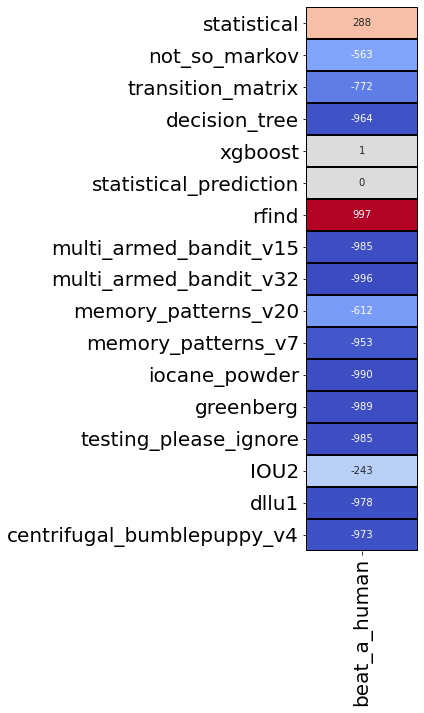

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from kaggle_environments import make, evaluate

env = make("rps", configuration={"episodeSteps": 1000})

list_names = [
    "statistical", 
    "not_so_markov", 
    "transition_matrix",
    "decision_tree",  
    "xgboost", 
    "statistical_prediction", 
    "rfind",
    "multi_armed_bandit_v15",
    "multi_armed_bandit_v32",
    "memory_patterns_v20",
    "memory_patterns_v7",
    "iocane_powder",
    "greenberg",
    "testing_please_ignore",
    "IOU2",
    "dllu1",
    "centrifugal_bumblepuppy_v4"
]
list_agents = [agent_name + ".py" for agent_name in list_names]

scores = np.zeros((len(list_names), 1), dtype=int)

for agent_number in range(len(list_names)):
    current_agent = list_agents[agent_number]
    current_score = evaluate(
        "rps", 
        ["beat_a_human.py", current_agent], 
        configuration={"episodeSteps": 1000}
    )
    scores[agent_number, 0] = current_score[0][0]
df_scores = pd.DataFrame(scores, index=list_names, columns=["beat_a_human"])

plt.figure(figsize=(2, 10))
sns.heatmap(
    df_scores, annot=True, cbar=False, 
    cmap="coolwarm", linewidths=1, linecolor="black", 
    fmt="d", vmin=-1000, vmax=1000,
)
plt.xticks(rotation=90, fontsize=20)
plt.yticks(rotation=360, fontsize=20);

All of a sudden, the "beat a human" bot successfully resist four strong opponents (statistical, statistical_prediction, xgboost, and simple rfind). In addition, some of the others are not able to defeat it 100% time. Very good for such a plain strategy!